# Implementation



In [1]:
import collections
import datetime
import glob
import pathlib
import pandas as pd
import seaborn as sns
# import tensorflow as tf
import os
import numpy as np
import scipy.signal as signal
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt
from IPython import display
from IPython import display
from matplotlib import pyplot as plt
from typing import Optional
from pathlib import Path
import numpy as np
import torch.utils.data
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from torch.autograd import Variable
import torch
import numpy as np
from scipy import signal

def plot_specgram(waveform, sample_rate):
    f, t, Sxx = signal.spectrogram(waveform, sample_rate)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

In [2]:
import torchaudio
# noise_whole = r"/data/ephraim/datasets/known_noise/undiff/exp_ar_j_real_2sec_divided/noises/machine.wav"
# noise_whole, sr = torchaudio.load(noise_whole)

import numpy as np
import torch


def normalize_tensor(tensor):
    """
    Normalize the input tensor using Z-score normalization.
    
    Args:
        tensor (torch.Tensor): Input tensor to be normalized.
        
    Returns:
        normalized_tensor (torch.Tensor): The normalized tensor.
        mean (float): Mean of the input tensor.
        std (float): Standard deviation of the input tensor.
    """
    mean = tensor.mean()
    std = tensor.std()
    
    # Avoid division by zero
    std = std if std > 0 else 1e-6
    
    normalized_tensor = (tensor - mean) / std
    return normalized_tensor, mean, std


def denormalize_tensor(normalized_tensor, mean, std):
    """
    Recover the original tensor from the normalized tensor.
    
    Args:
        normalized_tensor (torch.Tensor): Normalized tensor.
        mean (float): Mean used for normalization.
        std (float): Standard deviation used for normalization.
    
    Returns:
        torch.Tensor: The original tensor.
    """
    return normalized_tensor * std + mean


def create_ar_noise(n_samples, ar_coefs,order=1, dtype=torch.float32):
    
    mu=0
    sigma=1
    # Generate white noise
    white_noise = np.random.normal(mu, sigma, n_samples + order)

    # Initialize AR coefficients randomly
    # ar_coefs = np.random.uniform(AR_COEF_MIN,AR_COEF_MAX, order)

    # Generate AR noise
    ar_noise = np.zeros_like(white_noise)
    for i in range(order, n_samples + order):
        ar_noise[i] = np.dot(ar_coefs, ar_noise[i - order:i]) + white_noise[i]
    ar_noise = ar_noise[order:]  # Discard initial transient
    return torch.from_numpy(ar_noise).to(dtype).view(1,-1)
# ar_noise1 = create_ar_noise(16000, 0.9, 0.9)


sr=16000
# noise_whole = create_ar_noise(10000000, 0.9, 0.9, 1)
def create_ar_noise_batch(batch_size, n_samples, ar_coefs, order=1, sigma=1, dtype=torch.float32):
    """
    Efficiently generate a batch of AR noise samples using matrix operations.
    
    Parameters:
        batch_size (int): Number of AR noise samples in the batch.
        n_samples (int): Length of each AR noise sample.
        AR_COEF_MIN (float): Minimum value for AR coefficients.
        AR_COEF_MAX (float): Maximum value for AR coefficients.
        order (int): The order of the AR process.
        dtype (torch.dtype): The desired PyTorch tensor data type.

    Returns:
        torch.Tensor: Batch of AR noise samples with shape (batch_size, n_samples).
    """
    # Initialize white noise for the entire batch
    white_noise = torch.normal(0, 1, size=(batch_size, n_samples + order), dtype=dtype)

    # Convert AR coefficients to a tensor if needed
    if not isinstance(ar_coefs, torch.Tensor):
        ar_coefs = torch.tensor(ar_coefs, dtype=dtype)
    
    # Ensure AR coefficients are of the correct order
    assert ar_coefs.shape[0] == order, f"AR coefficients must have length {order}."
    
    # Expand AR coefficients for batch processing
    ar_coefs = ar_coefs.unsqueeze(0).expand(batch_size, -1)  # Shape: (batch_size, order)


    # Initialize the AR noise tensor
    ar_noise = torch.zeros_like(white_noise)

    # Iterate across time steps to compute AR noise
    for t in range(order, n_samples + order):
        # Slice the relevant previous values for all samples
        past_values = ar_noise[:, t - order:t]  # Shape: (batch_size, order)
        # Compute AR noise using matrix multiplication
        ar_noise[:, t] = (past_values * ar_coefs).sum(dim=1) + sigma*white_noise[:, t]

    # Remove the first `order` values to discard transient
    return ar_noise[:, order:]




In [3]:
21*16000

336000

In [4]:
#### Display tools
def plot_this(s,title=''):
    """

    """
    import pylab
    s = s.squeeze()
    if s.ndim ==1:
        pylab.plot(s)
    else:
        pylab.imshow(s,aspect='auto')
        pylab.title(title)
    pylab.show()

In [5]:
dataset_size=1*1
n_samples =64000
# ar_coefs = [ 0.4,-0.1, 0.1, -0.05,0.03]
ar_coefs = [0.9]
# ar_noise_batch = create_ar_noise_batch(batch_size=dataset_size, n_samples=n_samples, ar_coefs=[-0.9], order=1)
ar_noise_batch = create_ar_noise_batch(batch_size=dataset_size, n_samples=n_samples, ar_coefs=ar_coefs,sigma=3, order=len(ar_coefs))

# ar_noise_batch, mean_all, std_all = normalize_tensor(ar_noise_batch)

sr = 16000
new_sample_rate = 16000
# resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=new_sample_rate)
# noise_whole = resampler(noise_whole)
# print("old sr:", sr)
# print("new sr:", new_sample_rate)

print(ar_noise_batch.shape)
stop = 3
noise_sample1 = ar_noise_batch[0,  int(0*sr):int(stop*sr)]
noise_sample2 = ar_noise_batch[0,  int(stop*sr):int((stop+1)*sr)]
train_ar = ar_noise_batch[:,  int(0*sr):int(stop*sr)]
test_ar = ar_noise_batch[:,  int(stop*sr):int((stop+1)*sr)]
print(noise_sample1.shape)
print(noise_sample2.shape)

torch.Size([1, 64000])
torch.Size([48000])
torch.Size([16000])


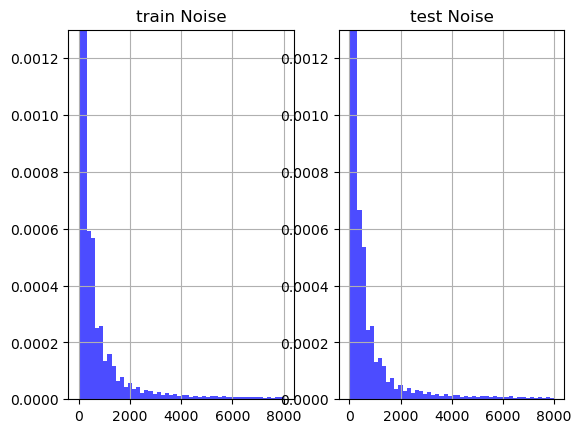

In [6]:



freqs1, magnitudes1 = signal.welch(noise_sample1.squeeze().cpu().numpy(), fs=16000)
freqs, magnitudes = signal.welch(noise_sample2.squeeze().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('train Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('test Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()

# Data Processing & Preparation.

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset


# Create datasets and data loaders
train_tensor = torch.tensor(train_ar, dtype=torch.float32)#.view(1,1,-1)
test_tensor = torch.tensor(test_ar, dtype=torch.float32)#.view(1,1,-1)
train_tensor.shape


/tmp/ipykernel_831276/1243974303.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_tensor = torch.tensor(train_ar, dtype=torch.float32)#.view(1,1,-1)
/tmp/ipykernel_831276/1243974303.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tensor = torch.tensor(test_ar, dtype=torch.float32)#.view(1,1,-1)


torch.Size([1, 48000])

In [8]:

def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.
    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear": ###chosen in default
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        # scale = 1000 / num_diffusion_timesteps
        beta_start = 0.0001  # scale * 0.0001
        beta_end = 0.02  # scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )

betas=get_named_beta_schedule("linear", 200)

alphas = 1.0 - betas
alphas_cumprod =  torch.from_numpy(np.cumprod(alphas, axis=0))
white_noise_diffusion = torch.normal(0,1,train_tensor.shape)
white_noise_diffusion2 = torch.normal(0,1,test_tensor.shape)
g_t = torch.sqrt((1-alphas_cumprod)/(alphas_cumprod))
t = np.random.randint(1,200,1)
cur_g_t = g_t[t]
real_Vtrain = train_tensor + white_noise_diffusion*g_t[t]
real_Vtest = test_tensor + white_noise_diffusion2*g_t[t]
# train_tensor = real_Vtrain
# test_tensor = real_Vtest
real_Vtrain.shape


torch.Size([1, 48000])

In [9]:
# train_full_tensors = train_tensor.squeeze().repeat(200,1,1).view(dataset_size,200,-1)
train_full_tensors = train_tensor.squeeze().view(dataset_size,1,-1)

# train_full_tensors = train_tensor.reshape(dataset_size,200,-1)

for i in [0]:
    cur_white_noise_diffusion = torch.normal(0,1,train_full_tensors[:,i,:].shape)
    train_full_tensors = train_full_tensors[:,i,:]#+cur_white_noise_diffusion*g_t[199]

# test_full_tensors = test_tensor.squeeze().repeat(200,1).view(200,1,-1)
test_full_tensors = test_tensor.squeeze().view(dataset_size,1,-1)

for i in [0]:
    cur_white_noise_diffusion = torch.normal(0,1,test_full_tensors[:,i,:].shape)
    test_full_tensors = test_full_tensors[:,i,:] #+cur_white_noise_diffusion*g_t[199]

print(train_full_tensors.shape)
print(test_full_tensors.shape)

torch.Size([1, 48000])
torch.Size([1, 16000])


In [10]:
import os
import pandas as pd
from torch.utils.data import Dataset


class NoiseDataset(Dataset):
    def __init__(self, data_tensor, gt_tensor):
        self.data_tensor =data_tensor
        self.gt_tensor = gt_tensor

    def __len__(self):
        return self.data_tensor.shape[0]

    def __getitem__(self, idx):
        item = self.data_tensor[idx,:,:]
        cur_gt = self.gt_tensor[idx]
        return item, cur_gt

class BatchNoiseDataset(Dataset):
    def __init__(self, data_tensor, gt_tensor):
        self.data_tensor =data_tensor
        self.gt_tensor = gt_tensor

    def __len__(self):
        return self.data_tensor.shape[0]

    def __getitem__(self, idx):
        item = self.data_tensor[idx,:,:]
        cur_gt = self.gt_tensor
        return item, cur_gt


In [11]:
def calc_stft(tensor):

    # Parameters
    sample_rate = 16000  # Sample rate in Hz
    n_fft = 512  # Number of FFT points
    win_length = n_fft  # Window length
    hop_length = int(win_length/2)  # Number of samples between frames
    window = torch.hann_window(win_length)  # Window function

    signal_ = tensor.view(-1)
    duration = max(tensor.shape)

    stft = torch.stft(signal_, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, return_complex=True)
    return stft, duration, sample_rate

def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    
from scipy.signal import firwin
def fir_filter(tensor, high=False, cutoff=6000,num_taps=101,device="cpu",sample_rate=16000):
    cutoff_freq = cutoff  # Cutoff frequency for the high-pass filter in Hz
    num_taps = num_taps  # Filter order (number of filter coefficients)
    if high:
        pass_zero = False
    else:
        pass_zero = True
    coefficients = firwin(num_taps, cutoff=cutoff_freq, pass_zero=pass_zero, fs=sample_rate)

    # Convert filter coefficients to a PyTorch tensor
    coefficients = torch.tensor(coefficients, dtype=torch.float32).to(device)

    pad_length = (num_taps - 1) // 2
    signal_padded = torch.nn.functional.pad(tensor.view(1, 1, -1), (pad_length, pad_length), mode='constant').to(device)

    # Apply the FIR filter to the signal using convolution
    filtered_signal = torch.nn.functional.conv1d(signal_padded.view(1, 1, -1), coefficients.view(1, 1, -1))
    return filtered_signal

In [12]:
import torch
import torch.nn.functional as F
import math

@torch.no_grad()
def generate_signal(model, 
                    initial_signal, 
                    num_samples=16000, 
                    device='cpu'):
    """
    Autoregressively generate a 1D signal from a trained MoG model.
    
    Parameters
    ----------
    model : nn.Module
        Your NetworkNoise6MoG model (or similar) that outputs (logits, means, log_sig).
    initial_signal : 1D or 2D torch.Tensor
        The starting samples of shape (init_length,) or (1, init_length).
        We'll treat this as the "warm-up" or "prompt."
    num_samples : int
        How many total output samples to generate (beyond the initial signal length).
    device : str
        Which device to run on ('cpu' or 'cuda').

    Returns
    -------
    generated : torch.Tensor
        A 1D tensor of length (initial_length + num_samples) containing the generated waveform.
    """
    model.eval()  # no dropout, no batchnorm updates

    # Make sure we have shape (1, 1, T)
    if initial_signal.dim() == 1:
        # shape => (1, 1, T)
        initial_signal = initial_signal.unsqueeze(0).unsqueeze(0)
    elif initial_signal.dim() == 2:
        # shape => (1, B, T) ?? We'll assume (1, T) => make (1, 1, T)
        initial_signal = initial_signal.unsqueeze(0)
    else:
        raise ValueError("initial_signal must be 1D or 2D tensor")

    initial_signal = initial_signal.to(device)
    generated_signal = initial_signal.clone()  # (1, 1, T_init)

    # Current length
    current_length = generated_signal.size(-1)

    for step in tqdm(range(num_samples)):
        # 1) Run model on all known samples so far
        logits, means, log_sig = model(generated_signal, "None")
        # logits, means, log_sig are shape (1, K, T_so_far)

        # 2) We want the distribution for the *last* time index => T_so_far - 1
        #    i.e. the newly predicted sample index
        t_idx = logits.size(-1) - 1  # last position

        # alpha_k = softmax over mixture dimension
        alpha = F.softmax(logits[:, :, t_idx], dim=1)  # shape (1, K)
        mu    = means[:, :, t_idx]                     # shape (1, K)
        s     = torch.exp(log_sig[:, :, t_idx])        # shape (1, K)
        
        # 3) Sample from the mixture
        # Pick which component k using alpha
        alpha = alpha.squeeze(0)  # (K,)
        mu    = mu.squeeze(0)     # (K,)
        s     = s.squeeze(0)      # (K,)

        # Choose mixture index k with probability alpha
        k = torch.multinomial(alpha, num_samples=1)  # shape (1,)

        # 4) Sample from Gaussian N(mu_k, s_k^2)
        chosen_mu = mu[k]
        chosen_s  = s[k]
        new_sample = torch.randn(1, device=device) * chosen_s + chosen_mu

        # 5) Append the new sample to the generated signal
        new_sample_reshaped = new_sample.view(1, 1, 1)  # (1, 1, 1)
        generated_signal = torch.cat([generated_signal, new_sample_reshaped], dim=-1)

    # Return shape => (T_final,) i.e. flatten out
    generated_signal = generated_signal.squeeze(0).squeeze(0)
    return generated_signal.cpu()


In [13]:

loss_array = {}
loss_test_array = {}
from torch import optim
from torch.optim.lr_scheduler import StepLR


def train(nets, steps,train_loader,test_loader,epochs ,device,mog=0,lr=0.001,scheduler=None):
    
    print("start ")
    for i in steps:
        model = nets[i]
        min_test_loss = 1000000000
        # if i ==1:
        #     break
        #Create TensorDatasets
        
        model.to(device)
        model.train()
        ii=0
        optimizer = optim.Adam(model.parameters(),lr=lr)
        if scheduler is not None:
            scheduler = StepLR(optimizer, step_size=1000, gamma=0.5)
        for epoch in tqdm(range(epochs)):
            running_loss = 0.0
            for batch_idx, (batch_tensor, gt_tensor) in enumerate(train_loader):
                ii+=1
                # data = data[0]
                # for data in train_loader:
                optimizer.zero_grad()
                batch_tensor = batch_tensor.to(device, dtype=torch.float)
                gt_tensor = gt_tensor.to(device, dtype=torch.float)
                
                if mog==0:
                    means, stds = model(batch_tensor, gt_tensor)
                    loss = model.casual_loss( means, stds, wav_tensor=batch_tensor).mean()
                else:
                    logits, means, log_sig = model(batch_tensor, cur_gt=None)
                    loss = model.casual_loss(logits, means, log_sig, batch_tensor).mean()
                
                
                
                # print("loss ",loss)
                # print("loss",loss)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                    
            # if epoch%50==0:
            #     # print(epoch)
            if epoch%1==0 or i > 90:
                with torch.no_grad():
                    for batch_idx, (test_inputs, gt_test) in enumerate(test_loader):

                        test_inputs = test_inputs.to(device, dtype=torch.float)
                        gt_test = gt_test.to(device, dtype=torch.float)
                        if mog==0:
                            meanst, stdst = model(test_inputs, gt_test)
                            loss_t = model.casual_loss( meanst, stdst, wav_tensor=test_inputs).mean()
                        else:
                            logits_t, meanst, log_sigt = model(test_inputs, cur_gt=None)
                            loss_t = model.casual_loss(logits_t, meanst, log_sigt, test_inputs).mean()   
                if i in loss_test_array:
                    loss_test_array[i].append(float(loss_t))
                else:
                    loss_test_array[i] = [float(loss_t)]
                if loss_t<=min_test_loss or epoch<10:
                    min_test_loss = loss_t
                # else:
                #     break
            

            if i in loss_array:
                loss_array[i].append(float(loss))
            else:
                loss_array[i] = [float(loss)]
        nets[i].parameters = model.parameters
        if scheduler is not None:
            scheduler.step()
        print(f"Model {i} Epoch {epoch+1}/{epochs}, Loss: {running_loss}, test Loss: {loss_t}")
    print(ii)
    return nets, loss_array, loss_test_array

In [14]:
def compare_spectrograms(original,modified):
    train_tensor_ftft, duration, sample_rate= calc_stft(original)
    filtered_signal_ftft,duration, sample_rate = calc_stft(modified)
    train_tensor_ftft = torch.abs(train_tensor_ftft)
    filtered_signal_ftft = torch.abs(filtered_signal_ftft)
    limit = sample_rate/2

    figure, axis = plt.subplots(1,2)
    vmin = np.vstack([train_tensor_ftft.squeeze(),filtered_signal_ftft.squeeze()]).min()
    vmax = np.vstack([train_tensor_ftft.squeeze(),filtered_signal_ftft.squeeze()]).max()
    im = axis[0].imshow(train_tensor_ftft, aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax, extent=[0, duration, 0, sample_rate / 2])
    axis[0].set_title('original Noise')
    axis[0].grid(True)
    axis[0].set_ylim(0.0, limit)
    axis[1].imshow(filtered_signal_ftft, aspect='auto', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax, extent=[0, duration, 0, sample_rate / 2])
    axis[1].set_title('model Noise')
    axis[1].grid(True)
    axis[1].set_ylim(0.0, limit)
    figure.colorbar(im,ax=axis.ravel().tolist(), label='Magnitude')
    plt.show()

In [15]:
import matplotlib.pyplot as plt

def plot_loss(loss_array,loss_test_array,j):
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(loss_array[j])
    axs[0].set_title('loss_array')
    axs[1].plot(loss_test_array[j])
    axs[1].set_title('loss_test_array')

In [16]:
from torch import nn
import torch.nn.utils as nn_utils



       
class CausalConv1dClassS(nn.Conv1d):
    def __init__(self,in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        pad = (kernel_size - 1) * dilation
        super().__init__(in_channels, out_channels, kernel_size, padding=pad, dilation=dilation, **kwargs)
    
    def forward(self, inputs):
        output = super().forward(inputs)
        if self.padding[0] != 0:
            output = output[:, :, :-self.padding[0]]
        return output



class NetworkNoise3_6MoG(nn.Module):
    def __init__(self, kernel_size=9, num_mixtures=1):
        super().__init__()
        self.kernel_size = kernel_size
        self.n_mixtures = num_mixtures

        # Convolutional Blocks with Gated Activation
        self.conv1 = nn.utils.parametrizations.weight_norm(
            CausalConv1dClassS(1, 2, kernel_size=kernel_size, dilation=1)
        )
        self.gate1 = nn.Conv1d(2, 2, kernel_size=1)

        self.conv2 = nn.utils.parametrizations.weight_norm(
            CausalConv1dClassS(2, 2, kernel_size=kernel_size, dilation=2)
        )
        self.gate2 = nn.Conv1d(2, 2, kernel_size=1)

        self.conv3 = nn.utils.parametrizations.weight_norm(
            CausalConv1dClassS(2, 2, kernel_size=kernel_size, dilation=4)
        )
        self.gate3 = nn.Conv1d(2, 2, kernel_size=1)

        self.conv4 = nn.utils.parametrizations.weight_norm(
            CausalConv1dClassS(2, 2, kernel_size=kernel_size, dilation=8)
        )
        self.gate4 = nn.Conv1d(2, 2, kernel_size=1)

        # Heads for Gaussian parameters
        self.conv_mean = nn.Conv1d(2, num_mixtures, kernel_size=1)
        self.conv_log_var = nn.Conv1d(2, num_mixtures, kernel_size=1)
        self.conv_log_probs = nn.Conv1d(2, num_mixtures, kernel_size=1)

    def gated_activation(self, x, gate):
        return torch.tanh(x) * torch.sigmoid(gate)

    def forward(self, x, cur_gt):
        x1 = self.conv1(x)
        x1 = self.gated_activation(x1, self.gate1(x1))

        x = self.conv2(x1)
        x = self.gated_activation(x, self.gate2(x))

        x = self.conv3(x)
        x = self.gated_activation(x, self.gate3(x))

        x = self.conv4(x)
        x = self.gated_activation(x, self.gate4(x))

        x = x + x1  # skip connection

        if self.n_mixtures == 1:
            # For single Gaussian, use channels: 0 for mean, 1 for log variance.
            means = self.conv_mean(x).squeeze(1)      # [B, T]
            log_var = self.conv_log_var(x).squeeze(1)   # [B, T]
            stds = torch.exp(0.5 * log_var)
            mixture_log_probs = torch.zeros_like(means)  # [B, T]
        else:
            means = self.conv_mean(x)        # [B, n_mixtures, T]
            log_var = self.conv_log_var(x)   # [B, n_mixtures, T]
            stds = torch.exp(0.5 * log_var)
            weights_logits = self.conv_log_probs(x)  # [B, n_mixtures, T]
            mixture_log_probs = F.log_softmax(weights_logits, dim=1)

        return mixture_log_probs, means, stds

    def calc_model_likelihood(self, mixture_log_probs, means, stds, wav_tensor, verbose=False):
        """
        Computes the log likelihood using a unified formula:

            log p(x) = logsumexp_k ( log(pi_k) + log N(x|mu_k,sigma_k) )

        When n_mixtures==1, mixture_log_probs are zeros so this reduces to the original single-Gaussian likelihood.

        Slices the time dimension similarly to your original NetworkNoise3:
          - target: from index (kernel_size+1) onward.
          - predictions: from index kernel_size to -1.

        Assumes wav_tensor shape [B, 1, T].
        """
        # Slice along the last dimension using ellipsis.
        target = wav_tensor.squeeze(1)[..., self.kernel_size+1:]   # [B, T_valid]
        means = means[..., self.kernel_size:-1]                     # now slices the time dimension
        stds  = stds[..., self.kernel_size:-1]
        mixture_log_probs = mixture_log_probs[..., self.kernel_size:-1]

        # Expand target for broadcasting: [B, 1, T_valid]
        target_exp = target.unsqueeze(1)
        
        # Compute per-component Gaussian log-density.
        log_pdf = (-0.5 * math.log(2 * np.pi)
                   - torch.log(stds)
                   - 0.5 * ((target_exp - means) / stds) ** 2)
        # Add mixture log weights.
        log_components = mixture_log_probs + log_pdf  # [B, n_mixtures, T_valid] or [B, T_valid] if single Gaussian
        # Marginalize over mixture components if applicable.
        if self.n_mixtures == 1:
            log_prob = log_components  # Already the correct log-density.
        else:
            log_prob = torch.logsumexp(log_components, dim=1)  # [B, T_valid]
        
        # Sum over time steps and average over batch.
        log_prob = log_prob.sum(dim=-1)  # [B]
        if verbose:
            print("Unified log-likelihood per sample:", log_prob)
        return log_prob.mean() / target.shape[-1]

    def casual_loss(self, mixture_log_probs, expected_means, expected_stds, wav_tensor):
        """
        Returns the negative log likelihood loss averaged over the batch.
        """
        ll = self.calc_model_likelihood(mixture_log_probs, expected_means, expected_stds, wav_tensor)
        return -ll

# class NetworkNoise3_6MoG(nn.Module):
#     def __init__(self, kernel_size=9, num_mixtures=1):
#         super().__init__()
#         self.kernel_size = kernel_size
#         self.n_mixtures=num_mixtures

#         # Convolutional Blocks with Gated Activation
#         self.conv1 = nn.utils.parametrizations.weight_norm(CausalConv1dClassS(1, 2, kernel_size=kernel_size, dilation=1))
#         self.gate1 = nn.Conv1d(2, 2, kernel_size=1)
        
#         self.conv2 = nn.utils.parametrizations.weight_norm(CausalConv1dClassS(2, 2, kernel_size=kernel_size, dilation=2))
#         self.gate2 = nn.Conv1d(2, 2, kernel_size=1)
        
#         self.conv3 = nn.utils.parametrizations.weight_norm(CausalConv1dClassS(2, 2, kernel_size=kernel_size, dilation=4))
#         self.gate3 = nn.Conv1d(2, 2, kernel_size=1)
        
#         self.conv4 = nn.utils.parametrizations.weight_norm(CausalConv1dClassS(2, 2, kernel_size=kernel_size, dilation=8))
#         self.gate4 = nn.Conv1d(2, 2, kernel_size=1)

#         self.conv_mean = nn.Conv1d(2, num_mixtures, kernel_size=1)
#         self.conv_log_var = nn.Conv1d(2, num_mixtures, kernel_size=1)
#         self.conv_log_probs = nn.Conv1d(2, num_mixtures, kernel_size=1)
    
#     def gated_activation(self, x, gate):
#         return torch.tanh(x) * torch.sigmoid(gate)
    
#     def forward(self, x, cur_gt):
#         x1 = self.conv1(x)
#         x1 = self.gated_activation(x1, self.gate1(x1))
        
#         x = self.conv2(x1)
#         x = self.gated_activation(x, self.gate2(x))
        
#         x = self.conv3(x)
#         x = self.gated_activation(x, self.gate3(x))
        
#         x = self.conv4(x)
#         x = self.gated_activation(x, self.gate4(x))
        
#         x = x + x1
        
#         means = self.conv_mean(x).squeeze(1)
#         log_var = self.conv_log_var(x).squeeze(1)
#         stds = torch.exp(0.5 * log_var)
        
        
#         if self.n_mixtures == 1:
#             mixture_log_probs = torch.zeros_like(means)  # [B, 1, T]
#         else:
#             weights_logits = self.conv_log_probs(x).squeeze(1)  # shape: [B, n_mixtures, T]
#             mixture_log_probs = F.log_softmax(weights_logits, dim=1)
        
#         return mixture_log_probs, means, stds
        

    
#     def calc_model_likelihood(self, mixture_log_probs,means, stds, wav_tensor, verbose=False):
#         """
#         Computes the log likelihood using a unified formula:
        
#             log p(x) = logsumexp_k ( log(pi_k) + log N(x|mu_k,sigma_k) )
        
#         When n_mixtures==1, mixture_log_probs are zeros so this reduces to the original single-Gaussian likelihood.
        
#         Slices the time dimension similarly to your original NetworkNoise3:
#           - target: from index (kernel_size+1) onward.
#           - predictions: from index kernel_size to -1.
        
#         Assumes wav_tensor shape [B, 1, T].
#         """
#         # mixture_log_probs, means, stds = output  # shapes: [B, n_mixtures, T]
        
#         # Slicing indices as in your original network.
#         # Original: wav_tensor = wav_tensor.squeeze(axis=1)[:, self.kernel_size+1:]
#         #           means = expected_means.squeeze(axis=1)[:, self.kernel_size:-1]
#         target = wav_tensor.squeeze(1)[:, self.kernel_size+1:]  # [B, T_valid]
#         means = means[ :, self.kernel_size:-1]                # [B, n_mixtures, T_valid]
#         stds  = stds[ :, self.kernel_size:-1]
#         mixture_log_probs = mixture_log_probs[ ..., self.kernel_size:-1]
        
#         # Expand target for broadcasting: [B, 1, T_valid]
#         target_exp = target.unsqueeze(1)
        
#         # Compute per-component Gaussian log-density:
#         log_pdf = (-0.5 * math.log(2 * np.pi)
#                    - torch.log(stds)
#                    - 0.5 * ((target_exp - means) / stds) ** 2)
#         # Add mixture log weights.
#         log_components = mixture_log_probs + log_pdf  # [B, n_mixtures, T_valid]
#         # Marginalize over mixture components.
#         log_prob = torch.logsumexp(log_components, dim=1)  # [B, T_valid]
#         # Sum over time steps.
#         log_prob = log_prob.sum(dim=-1)  # [B]
#         if verbose:
#             print("Unified log-likelihood per sample:", log_prob)
#         return log_prob.mean()/target.shape[-1]
    
#     def casual_loss(self, mixture_log_probs,expected_means, expected_stds, wav_tensor):
#         """
#         Returns the negative log likelihood loss averaged over the batch.
#         """
#         ll = self.calc_model_likelihood(mixture_log_probs,expected_means, expected_stds, wav_tensor)
    
#         return -ll
    
    
        # def calc_model_likelihood(self, expected_means, expected_stds, wav_tensor, verbose=False):
        
    #     wav_tensor = wav_tensor.squeeze(axis=1)[:,self.kernel_size+1:]
    #     means_=expected_means.squeeze(axis=1)[:,self.kernel_size:-1]
    #     stds_ = expected_stds.squeeze(axis=1)[:,self.kernel_size:-1]
    #     # print(wav_tensor.shape)
    #     # print(means_.shape)

    #     exp_all = -(1/2)*((torch.square(wav_tensor-means_)/torch.square(stds_)))
    #     param_all = 1/(np.sqrt(2*np.pi)*stds_)
    #     model_likelihood1 = torch.sum(torch.log(param_all), axis=-1) 
    #     model_likelihood2 = torch.sum(exp_all, axis=-1) 

    #     if verbose:
    #         print("model_likelihood1: ", model_likelihood1)
    #         print("model_likelihood2: ", model_likelihood2)
    #     likelihood = model_likelihood1 + model_likelihood2
    #     return likelihood.mean()/wav_tensor.shape[-1]
    
    # def casual_loss(self, expected_means, expected_stds, wav_tensor):
    #     model_likelihood = self.calc_model_likelihood(expected_means, expected_stds, wav_tensor)
    #     return -model_likelihood  

In [17]:

torch.cuda.empty_cache()

start 


/tmp/ipykernel_831276/4188592739.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(epochs)):


  0%|          | 0/1000 [00:00<?, ?it/s]

Model 0 Epoch 1000/1000, Loss: 2.5394225120544434, test Loss: 2.549744129180908
1000


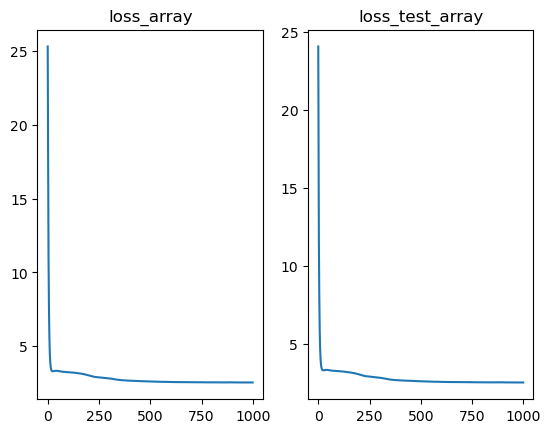

In [26]:
import torch.optim as optim
# from network_factory import NetworkNoise3MoG

nets = [NetworkNoise3_6MoG(num_mixtures=2) for i in range(200)]
epochs = 1000
device = "cpu"

loss_array = {}
loss_test_array = {}
i=0
train_dataset = BatchNoiseDataset(train_full_tensors.reshape(dataset_size,1,-1),g_t[i])
test_dataset = BatchNoiseDataset(test_full_tensors.reshape(dataset_size,1,-1),g_t[i])
lr=0.05
#Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True) #todo: numbers
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)


nets,loss_array,loss_test_array = train(steps=[0],nets=nets,train_loader=train_loader,test_loader=test_loader,epochs=epochs,device=device,mog=1,lr=lr)#nets, steps,train_loader,test_loader,epochs

plot_loss(loss_array,loss_test_array,0)

In [28]:
loss_array[0][-1]

2.5394225120544434

In [27]:
model=nets[0]
model.to(device)
model.eval()

NetworkNoise3_6MoG(
  (conv1): ParametrizedCausalConv1dClassS(
    1, 2, kernel_size=(9,), stride=(1,), padding=(8,)
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): _WeightNorm()
      )
    )
  )
  (gate1): Conv1d(2, 2, kernel_size=(1,), stride=(1,))
  (conv2): ParametrizedCausalConv1dClassS(
    2, 2, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(2,)
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): _WeightNorm()
      )
    )
  )
  (gate2): Conv1d(2, 2, kernel_size=(1,), stride=(1,))
  (conv3): ParametrizedCausalConv1dClassS(
    2, 2, kernel_size=(9,), stride=(1,), padding=(32,), dilation=(4,)
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): _WeightNorm()
      )
    )
  )
  (gate3): Conv1d(2, 2, kernel_size=(1,), stride=(1,))
  (conv4): ParametrizedCausalConv1dClassS(
    2, 2, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(8,)
    (parametrizations): M

In [ ]:
model

In [21]:
# l = 100000
# output_train = model(train_full_tensors.view(1,1,-1)[:,:,1000:l].to(device),g_t[0].to(device))
# mu, log_sig = output_train
# loss_train = model.casual_loss( mu, log_sig, train_full_tensors.view(1,1,-1)[:,:,1000:l].to(device), offset=False)
# loss_train

# output = model(test_full_tensors.view(1,1,-1).to(device),g_t[0].to(device))
# mu, log_sig = output
# loss = model.casual_loss( mu, log_sig, test_full_tensors.view(1,1,-1).to(device), offset=False)
# print(loss)
# plot_this(output[0][:,0:500].cpu().detach().numpy())

In [29]:
from torch import nn
test_tensors = test_full_tensors.reshape(1,1,-1)
device="cpu"
j=0
long = 2000
window = 10000
logits_array = torch.zeros((long+window+1))
mu_array = torch.zeros((long+window+1))
sig_array = torch.zeros((long+window+1))

model = model.to(device)
cur_input = test_tensors[0,0,:35000].clone().view(1,1,-1)
cur_input[0,0,window+1:] = 0
print(cur_input[0,0,window])
print(cur_input[0,0,window+1])
cur_input = cur_input.to(device, dtype=torch.float)
print(cur_input.shape)


initial_signal=cur_input[:,:,:window].squeeze()
num_samples=long # generate 2000 new samples


model.eval()  # set model to evaluation mode
generated_signal = cur_input[0,0,:window].clone().to(device)
print("generated.shape:", generated_signal.shape)

def compute_receptive_field(model):
    R = 1  # Start by counting the current time-step itself
    for layer in model.modules():
        if isinstance(layer, nn.Conv1d):
            # layer.kernel_size and layer.dilation are tuples (for 1D conv, they have length=1)
            k = layer.kernel_size[0]
            d = layer.dilation[0]
            R += (k - 1) * d
    return R
receptive_field =compute_receptive_field(model)

# Ensure no gradients are computed during generation.
with torch.no_grad():
    for k in range(long):
        # Use only the last 'receptive_field' samples as input.
        input_signal = generated_signal[ window-receptive_field+k:window+k]

        # Run the model.
        output = model(input_signal.reshape(1,1,-1),"none")
        mixture_log_probs, means, stds = output  # shapes: [B, n_mixtures, T]
        # We want the prediction for the "next" sample: use the last time step.
        mixture_log_probs_t = mixture_log_probs[ :, -1]  # shape: [B, n_mixtures]
        means_t = means[ :, -1]                          # shape: [B, n_mixtures]
        stds_t  = stds[ :, -1]  
        mu_array[window+k] = means_t
        sig_array[window+k] = stds_t
        
        # Sampling from the predicted distribution.
        if model.n_mixtures == 1:
            # Single Gaussian: sample from N(mean, std).
            # sample = means_t.squeeze(1) + stds_t.squeeze(1) * torch.randn_like(means_t.squeeze(1))
            sample = means_t + stds_t * torch.randn_like(means_t)
        else:
            # Mixture of Gaussians:
            # Convert log mixture weights to probabilities.
            probs = torch.exp(mixture_log_probs_t)  # [B, n_mixtures]
            # For each batch element, sample a mixture component.
            # torch.multinomial expects non-negative probabilities.
            indices = torch.multinomial(probs, num_samples=1).squeeze(1)  # [B]
            # Gather the mean and std for the chosen component.
            chosen_means = means_t.gather(1, indices.unsqueeze(1)).squeeze(1)  # [B]
            chosen_stds  = stds_t.gather(1, indices.unsqueeze(1)).squeeze(1)   # [B]
            sample = chosen_means + chosen_stds * torch.randn_like(chosen_means)
        
        # Append the new sample to the generated sequence.
        # Reshape sample to [B, 1, 1] so that it can be concatenated on the time dimension.
        sample = sample
        generated_signal = torch.cat([generated_signal, sample], dim=0)
        # print(_)

tensor(-4.4447)
tensor(0.)
torch.Size([1, 1, 16000])
generated.shape: torch.Size([10000])


RuntimeError: expand(torch.FloatTensor{[121]}, size=[]): the number of sizes provided (0) must be greater or equal to the number of dimensions in the tensor (1)

In [23]:
sig_array.mean()

tensor(0.5056)

In [25]:
output[0][-1][-1]

tensor(0.)

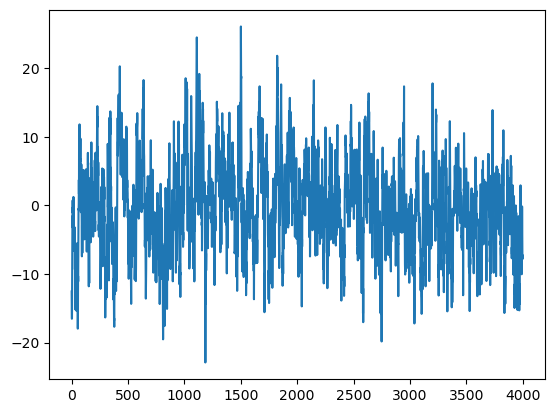

In [24]:
plot_this(generated_signal[window-long:window+long].cpu().detach().numpy())

In [25]:
mu_array[window:window+500].mean()

tensor(0.4681)

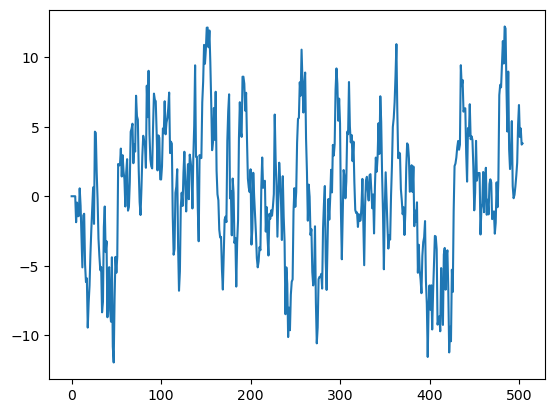

In [26]:
plot_this(mu_array[window-5:window+500].cpu().detach().numpy())

In [27]:
mm = sig_array[window:window+long].mean()
print(mm)


tensor(3.0337)


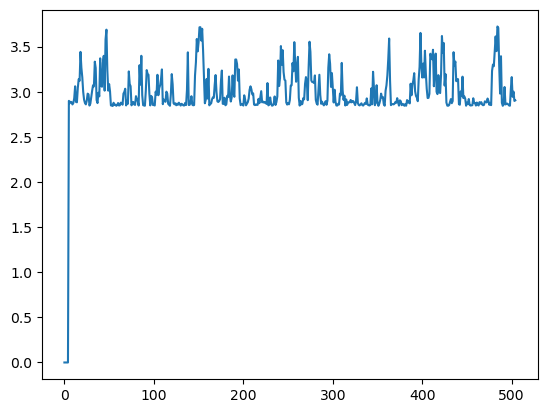

In [28]:
plot_this(sig_array[window-5:window+500].cpu().detach().numpy())

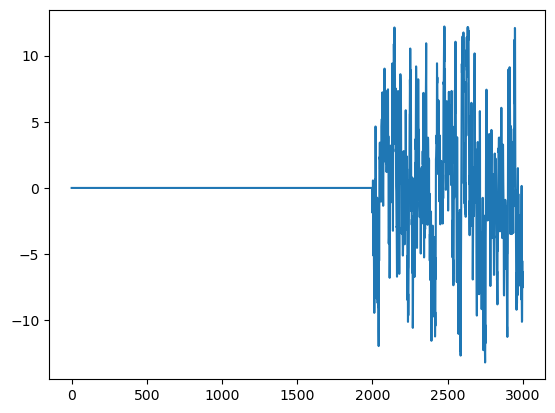

In [29]:
plot_this(mu_array[window-2000:window+1000].cpu().detach().numpy())

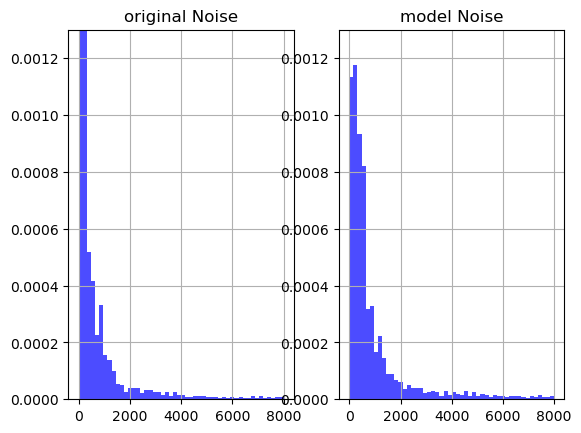

In [30]:
cur_input = generated_signal
train_inputs = train_full_tensors.reshape(1,1,-1)
freqs1, magnitudes1 = signal.welch(train_inputs[0,0,window:window+long].squeeze().cpu().detach().numpy(), fs=16000)
freqs, magnitudes = signal.welch(cur_input[window:window+long].squeeze().detach().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()

start 


/tmp/ipykernel_831276/4188592739.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(epochs)):


  0%|          | 0/3000 [00:00<?, ?it/s]

Model 0 Epoch 3000/3000, Loss: 2.535954713821411, test Loss: 2.5429751873016357
3000


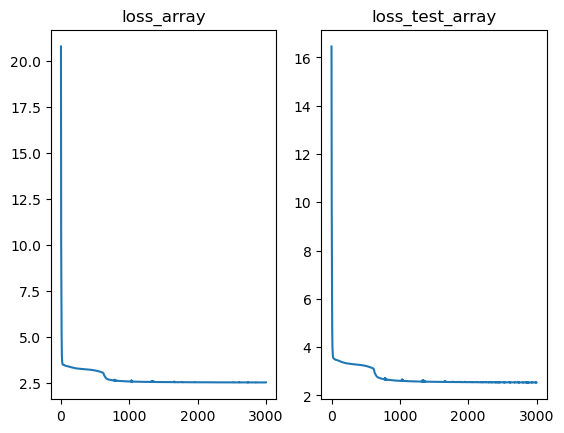

In [30]:
n_mixtures = 2
nets = [NetworkNoise3_6MoG(num_mixtures=n_mixtures) for i in range(200)]
epochs = 3000
device = "cpu"

loss_array = {}
loss_test_array = {}
i=0
train_dataset = BatchNoiseDataset(train_full_tensors.reshape(dataset_size,1,-1),g_t[i])
test_dataset = BatchNoiseDataset(test_full_tensors.reshape(dataset_size,1,-1),g_t[i])
lr=0.05
#Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True) #todo: numbers
test_loader = DataLoader(dataset=test_dataset, batch_size=8, shuffle=False)


nets,loss_array,loss_test_array = train(steps=[0],nets=nets,train_loader=train_loader,test_loader=test_loader,epochs=epochs,device=device,mog=n_mixtures,lr=lr)#nets, steps,train_loader,test_loader,epochs

plot_loss(loss_array,loss_test_array,0)

In [31]:
loss_array[0][-1]

2.535954713821411

In [32]:
model=nets[0]
model.to(device)
model.eval()

from torch import nn
test_tensors = test_full_tensors.reshape(1,1,-1)
device="cpu"
j=0
long = 2000
window = 10000
logits_array = torch.zeros((long+window+1,n_mixtures))
mu_array = torch.zeros((long+window+1,n_mixtures))
sig_array = torch.zeros((long+window+1,n_mixtures))

model = model.to(device)
cur_input = test_tensors[0,0,:35000].clone().view(1,1,-1)
cur_input[0,0,window+1:] = 0
print(cur_input[0,0,window])
print(cur_input[0,0,window+1])
cur_input = cur_input.to(device, dtype=torch.float)
print(cur_input.shape)


initial_signal=cur_input[:,:,:window].squeeze()
num_samples=long # generate 2000 new samples


model.eval()  # set model to evaluation mode
generated_signal = cur_input[0,0,:window].clone().to(device)
print("generated.shape:", generated_signal.shape)

def compute_receptive_field(model):
    R = 1  # Start by counting the current time-step itself
    for layer in model.modules():
        if isinstance(layer, nn.Conv1d):
            # layer.kernel_size and layer.dilation are tuples (for 1D conv, they have length=1)
            k = layer.kernel_size[0]
            d = layer.dilation[0]
            R += (k - 1) * d
    return R
receptive_field =compute_receptive_field(model)

# Ensure no gradients are computed during generation.
with torch.no_grad():
    for k in range(long):
        # Use only the last 'receptive_field' samples as input.
        input_signal = generated_signal[ window-receptive_field+k:window+k]

        # Run the model.
        output = model(input_signal.reshape(1,1,-1),"none")
        mixture_log_probs, means, stds = output  # shapes: [B, n_mixtures, T]
        # We want the prediction for the "next" sample: use the last time step.
        mixture_log_probs_t = mixture_log_probs[:, :, -1]  # shape: [B, n_mixtures]
        means_t = means[:, :, -1]                          # shape: [B, n_mixtures]
        stds_t  = stds[ :,:, -1]  
        mu_array[window+k] = means_t
        
        sig_array[window+k] = stds_t
        
        # Sampling from the predicted distribution.
        if model.n_mixtures == 1:
            # Single Gaussian: sample from N(mean, std).
            # sample = means_t.squeeze(1) + stds_t.squeeze(1) * torch.randn_like(means_t.squeeze(1))
            sample = means_t + stds_t * torch.randn_like(means_t)
        else:
            # Mixture of Gaussians:
            # Convert log mixture weights to probabilities.
            probs = torch.exp(mixture_log_probs_t)  # [B, n_mixtures]
            # For each batch element, sample a mixture component.
            # torch.multinomial expects non-negative probabilities.
            indices = torch.multinomial(probs, num_samples=1)#.squeeze(1)  # [B]
            # Gather the mean and std for the chosen component.
            chosen_means = means_t.gather(1, indices)#.squeeze(1)  # [B]
            chosen_stds  = stds_t.gather(1, indices)#.squeeze(1)   # [B]
            sample = chosen_means + chosen_stds * torch.randn_like(chosen_means)
        
        # Append the new sample to the generated sequence.
        # Reshape sample to [B, 1, 1] so that it can be concatenated on the time dimension.
        sample = sample.squeeze(1)
        generated_signal = torch.cat([generated_signal, sample], dim=0)

tensor(-4.4447)
tensor(0.)
torch.Size([1, 1, 16000])
generated.shape: torch.Size([10000])


In [45]:
probs

tensor([[2.4207e-06, 1.0000e+00]])

In [43]:
means_t

tensor([[-6.5472, 10.1569]])

In [47]:
mm = sig_array[window:window+long].mean()
print(mm)

tensor(2.2771)


In [51]:
mu_array.shape

torch.Size([12001, 2])

In [55]:
mm =mu_array[window:window+long,0].mean()
print(mm)

tensor(-5.4903)


In [57]:
mm =sig_array[window:window+long,1].mean()
print(mm)

tensor(3.0684)


In [54]:
generated_signal.mean()

tensor(-0.8699)

tensor(2.2771)


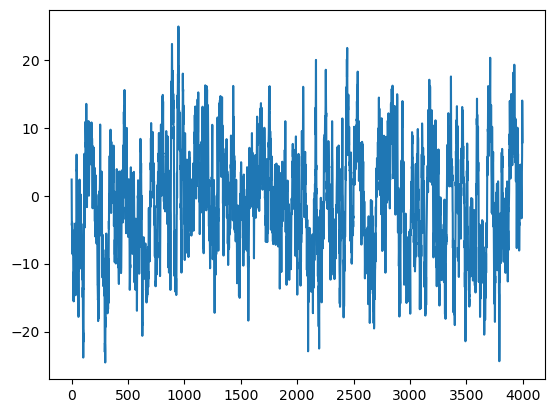

tensor(-3.7687)

In [46]:
mm = sig_array[window:window+long].mean()
print(mm)
plot_this(generated_signal[window-long:window+long].cpu().detach().numpy())
mu_array[window:window+500].mean()

In [34]:
# mm = sig_array[window:window+long]


tensor(2.2217)


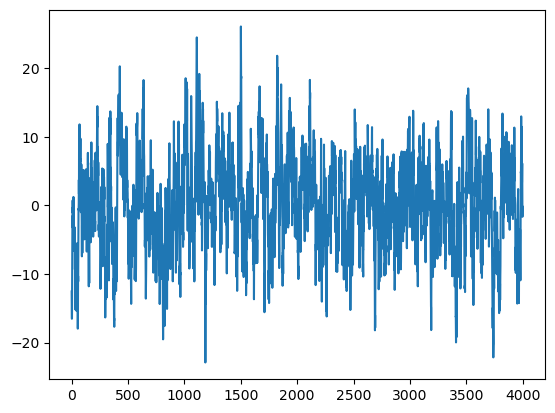

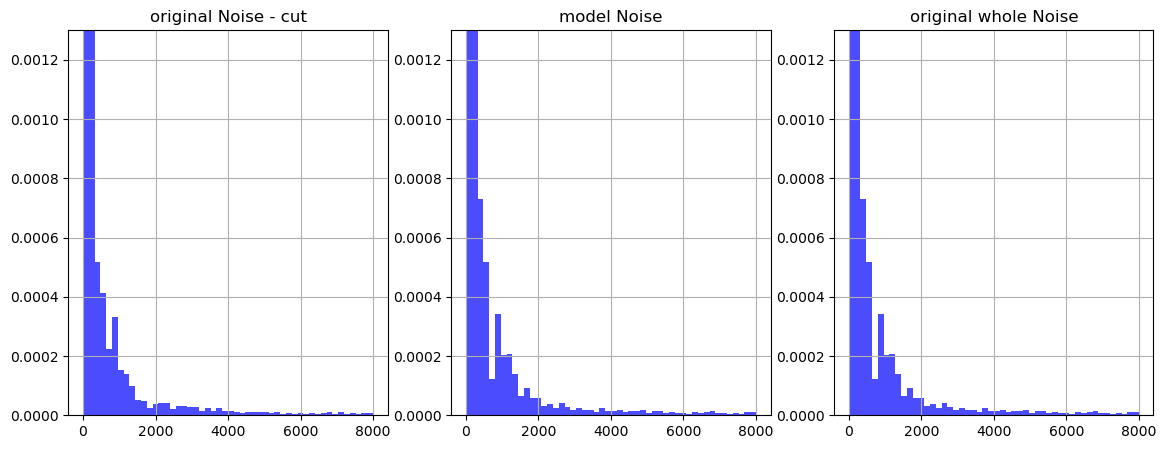

In [35]:
mm = sig_array[window:window+long].mean()
print(mm)
plot_this(generated_signal[window-long:window+long].cpu().detach().numpy())
mu_array[window:window+500].mean()

cur_input = generated_signal
train_inputs = train_full_tensors.reshape(1,1,-1)
freqs1, magnitudes1 = signal.welch(train_inputs[0,0,window:window+long].squeeze().cpu().detach().numpy(), fs=16000)
freqs, magnitudes = signal.welch(cur_input[window:window+long].squeeze().detach().cpu(), fs=16000)
freqs2, magnitudes2 = signal.welch(train_inputs.squeeze().cpu().detach().numpy(), fs=16000)

limit = 0.0013
figure, axis = plt.subplots(1,3, figsize=(14,5))
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Noise - cut')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
axis[2].hist(freqs2, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[2].set_title('original whole Noise')
axis[2].grid(True)
axis[2].set_ylim(0.0, limit)
plt.show()

In [203]:
save_dir = "/data/ephraim/for_paper/plots/"
figure.savefig(os.path.join(save_dir, "subplot_figure.png"), dpi=300, bbox_inches='tight')

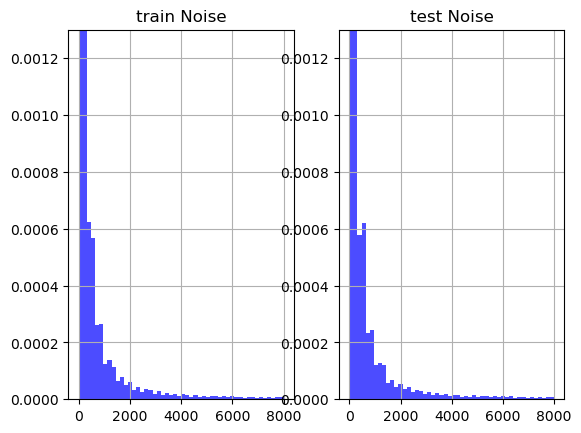

In [194]:
freqs1, magnitudes1 = signal.welch(noise_sample1.squeeze().cpu().numpy(), fs=16000)
freqs, magnitudes = signal.welch(noise_sample2.squeeze().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('train Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('test Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()

In [195]:
plt.hist(output_test_low_std[0,:].cpu(),bins=50)

NameError: name 'output_test_low_std' is not defined

In [ ]:
audio_output.shape

torch.Size([8, 560000])

In [191]:
from torch import nn



class SimpleAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.tensor(0.1))  # Initial value of 'a'
        self.b = nn.Parameter(torch.tensor(0.1))  # Initial value of 'b'
        # self.c = nn.Parameter(torch.tensor(0.1)) 
        # self.d = nn.Parameter(torch.tensor(0.1)) 

    def forward(self, x, cur_gt):
        means = torch.zeros_like(x)
        stds = torch.zeros_like(x)
        for i in range(x.shape[-1]):
            if i==1 or i==0:
                continue
            means[:,:,i] = self.a* x[:,:,i-1]#+self.d* x[:,:,i-2] +self.c
            stds[:,:,i] = self.b 
        return means, stds
    
    def forward_once(self, x, cur_gt):
        means = self.a* x[:,:,i-1]# +self.d* x[:,:,i-2] +self.c
        stds = self.b 
        return means, stds
    
    def calc_model_likelihood(self, expected_means, expected_stds, wav_tensor, verbose=False):
        wav_tensor = wav_tensor.squeeze(axis=1)[:,3:]
        means_=expected_means.squeeze(axis=1)[:,3:]
        stds_ = expected_stds.squeeze(axis=1)[:,3:]


        exp_all = -(1/2)*((torch.square(wav_tensor-means_)/torch.square(stds_)))
        param_all = 1/(np.sqrt(2*np.pi)*stds_)
        model_likelihood1 = torch.sum(torch.log(param_all), axis=-1) 
        model_likelihood2 = torch.sum(exp_all, axis=-1) 

        if verbose:
            print("model_likelihood1: ", model_likelihood1)
            print("model_likelihood2: ", model_likelihood2)
        return model_likelihood1 + model_likelihood2
    
    def casual_loss(self, expected_means, expected_stds, wav_tensor):
        model_likelihood = self.calc_model_likelihood(expected_means, expected_stds, wav_tensor)
        return -model_likelihood   
    

In [192]:
train_full_tensors.shape

torch.Size([256, 560000])

start 


/tmp/ipykernel_147609/174528573.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm(range(epochs)):


  0%|          | 0/30 [00:00<?, ?it/s]

0
Model 0 Epoch 30/30, Loss: 156963.8955078125, test Loss: 9749.388671875
480


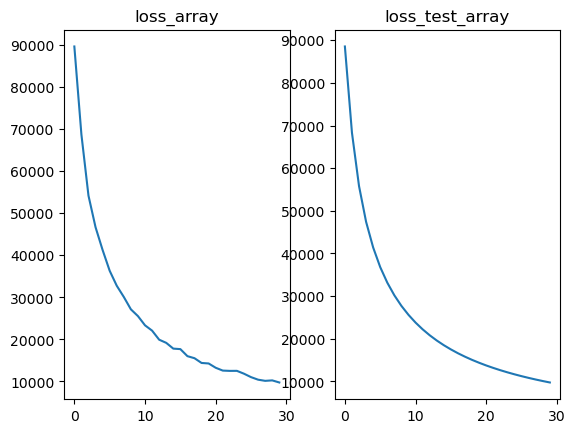

In [194]:
import torch.optim as optim
nets_g = [SimpleAR()]
epochs = 30

loss_array = {}
loss_test_array = {}
i=0
# train_full_tensors_n, mean, std = normalize_tensor(train_full_tensors)
# test_full_tensors_n, mean, std = normalize_tensor(test_full_tensors)
train_dataset = BatchNoiseDataset(train_full_tensors[:,:3000].reshape(dataset_size,1,-1),g_t[i])
test_dataset = BatchNoiseDataset(test_full_tensors[:,:3000].reshape(dataset_size,1,-1),g_t[i])

#Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True) #todo: numbers
test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)


nets_g,loss_array_high,loss_test_array_high = train(steps=[0],nets=nets_g,train_loader=train_loader,test_loader=test_loader)

plot_loss(loss_array_high,loss_test_array_high,0)

In [195]:
model5 = nets_g[0]
model5.eval()
for batch_idx, (train_inputs4, gt_test) in enumerate(train_loader):
    break
# test_inputs, gt_test = test_dataset.__getitem__(j)
train_inputs4 = train_inputs4.to("cuda:1", dtype=torch.float)

In [196]:
# loss = model5.casual_loss( output_test_low_mean.to("cuda:1"), output_test_low_std.to("cuda:1"), train_inputs4).mean() ##.mean()

In [197]:
loss

NameError: name 'loss' is not defined

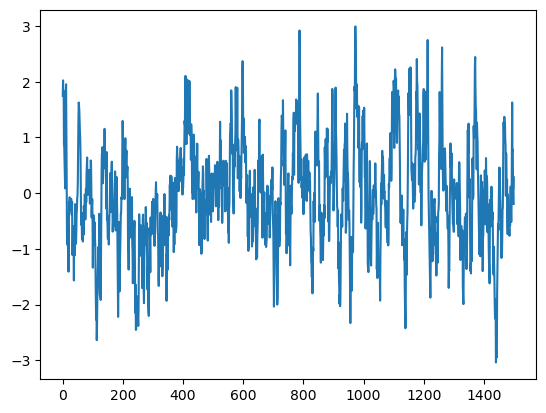

In [198]:
plot_this(cur_input4[0,0,window-500:window+1000].cpu().detach().numpy())

In [199]:
long = 999
window = 1000
mu_array4 = torch.zeros((long+window+1))
sig_array4 = torch.zeros((long+window+1))

model5 = model5.to("cuda:1")
cur_input4 = train_inputs4[0,0,:3000].clone().view(1,1,-1)
cur_input4[0,0,window+1:] = 0
print(cur_input4[0,0,window])
print(cur_input4[0,0,window+1])
cur_input4 = cur_input4.to("cuda:1", dtype=torch.float)
print(cur_input4.shape)
# cur_input = cur_train[0,0,:window].view(1,1,-1)
for i in tqdm(range(long)):
    if i >long:
        continue

    mu,sig = model5.forward_once(cur_input4[0,0,:window+i+1].view(1,1,-1),g_t[j])
    mu_ = mu[0,-1]
    sig_ = sig
    
    mu_array4[window+i] = mu_
    sig_array4[window+i] = sig_
    added = torch.normal(mu_.cpu(), sig_.cpu())#.reshape(1,1,1)
    # print(mu_,sig_,added)
    cur_input4[0,0,window+i+1] = added

    torch.cuda.empty_cache()

tensor(0.6467, device='cuda:1')
tensor(0., device='cuda:1')
torch.Size([1, 1, 3000])


/tmp/ipykernel_147609/615584594.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(long)):


  0%|          | 0/999 [00:00<?, ?it/s]

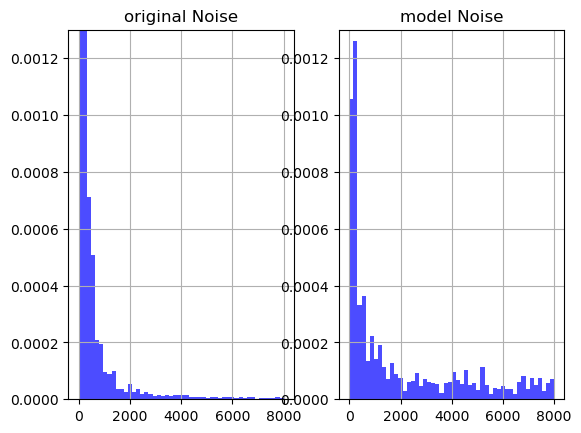

In [200]:
freqs1, magnitudes1 = signal.welch(train_inputs4[0,0,window:window+5000].squeeze().cpu().detach().numpy(), fs=16000)
freqs, magnitudes = signal.welch(cur_input4[0,0,window:window+5000].squeeze().detach().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()

In [201]:
for name, param in nets_g[0].named_parameters():
    if param.requires_grad:
        print(name, param.data)

a tensor(0.3514, device='cuda:1')
b tensor(0.2607, device='cuda:1')


In [ ]:
#LMS

In [49]:

batch_size_ = 1
order=1
white_noise = torch.normal(0, 1, size=(1, 5001))

# Expand AR coefficients for batch processing
ar_coefs = 0.9  # Shape: (batch_size, order)


# Initialize the AR noise tensor
ar_noise_ = torch.zeros_like(white_noise)

# Iterate across time steps to compute AR noise
for t in range(1, 5001):
    past_values = ar_noise_[:, t - 1:t]  # Shape: (batch_size, order)
    # Compute AR noise using matrix multiplication
    ar_noise_[:, t] = (past_values * ar_coefs).sum(dim=1) + white_noise[:, t]

# Remove the first `order` values to discard transient
ar_noise_ =  ar_noise_[:, order:]

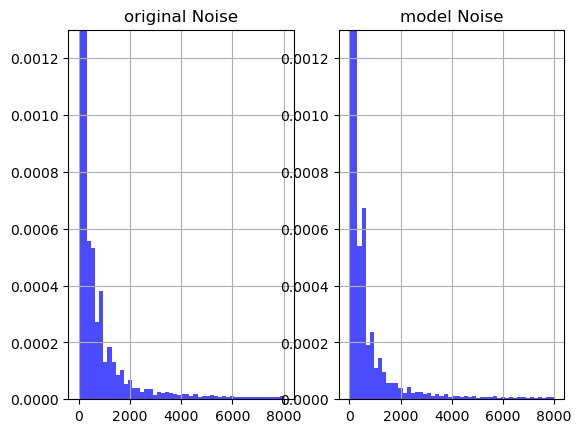

In [51]:
freqs1, magnitudes1 = signal.welch(train_inputs4[0,0,window:window+5000].squeeze().cpu().detach().numpy(), fs=16000)
freqs, magnitudes = signal.welch(ar_noise_.squeeze().detach().cpu(), fs=16000)
limit = 0.0013
figure, axis = plt.subplots(1,2)
axis[0].hist(freqs1, bins=50, weights=magnitudes1, density=True, color='b', alpha=0.7)
axis[0].set_title('original Noise')
axis[0].grid(True)
axis[0].set_ylim(0.0, limit)
axis[1].hist(freqs, bins=50, weights=magnitudes, density=True, color='b', alpha=0.7)
axis[1].set_title('model Noise')
axis[1].grid(True)
axis[1].set_ylim(0.0, limit)
plt.show()